In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import jax.numpy as jnp
from jax import random, jacfwd, vmap
from jax_nn import TrainModelInBatches, forward_pass, predictions, derivative

import matplotlib.pyplot as plt
# from jax_nn import forward_pass

filename_saved_model='./models/'

In [4]:
training_data = np.load('./training_data/training_data_disco_eb_custom_k.npz')
training_data = {key: training_data[key] for key in training_data.files}
print(training_data.keys())

# cosmo_params_names = training_data['cosmo_params_names']
cosmo_params_samples = training_data['cosmo_params_samples']
power_spectra = training_data['power_spectra']
k_modes = training_data['k_modes']

# print('cosmo_params_names:', cosmo_params_names)
print('cosmo_params_samples.shape =', cosmo_params_samples.shape)
print('k_modes.shape =', k_modes.shape)
print('power_spectra.shape = ', power_spectra.shape)

dict_keys(['cosmo_params_samples', 'k_modes', 'power_spectra'])
cosmo_params_samples.shape = (10000, 6)
k_modes.shape = (420,)
power_spectra.shape =  (10000, 420)


In [3]:
# training_features = np.log10(power_spectra + 1e-30)[:9000] #power_spectra[:9000]
# training_parameters = cosmo_params_samples[:9000]

In [5]:
# hyperparameters
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
batch_sizes = [512, 512, 512, 512, 512]
patience_values = [40,40,40,40,40]
max_epochs = [10000,10000,10000,10000,10000]
n_hidden = [512, 512, 512, 512]
validation_split = 0.1
seed = random.PRNGKey(5)

modes = k_modes
training_features = np.log10(power_spectra + 1e-30)[:9000] #power_spectra[:9000]
training_parameters = cosmo_params_samples[:9000]

#train in batches
weights, hyper_params = TrainModelInBatches(training_parameters=training_parameters,
                                        training_features=training_features,
                                        filename_saved_model=filename_saved_model,
                                        modes = k_modes,
                                        n_hidden=n_hidden,
                                        validation_split=validation_split,
                                        learning_rates=learning_rates,
                                        batch_sizes=batch_sizes,
                                        patience_values=patience_values,
                                        max_epochs=max_epochs,
                                        seed=seed)


LMPS_w_h = weights, hyper_params
# jnp.save('your/saving/path')


Initialized cosmopower_NN model, 
mapping 6 input parameters to 420 output modes, 
using 4 hidden layers, 
with [512, 512, 512, 512] nodes, respectively. 

learning rate = 0.01, batch size = 512


  2%|▏         | 156/10000 [00:19<20:09,  8.14it/s, loss=0.022419792] 


Validation loss = 0.008064442
R2 score = 0.9984921418480553
final validation loss: 0.022419792
final r2 score: 0.9984921418480553
Reached max number of epochs. Validation loss = 0.008064442
learning rate = 0.001, batch size = 512


  1%|          | 100/10000 [00:03<06:00, 27.43it/s, loss=0.0033979537]


Validation loss = 0.0011649836
R2 score = 0.9999665449790762
final validation loss: 0.0033979537
final r2 score: 0.9999665449790762
Reached max number of epochs. Validation loss = 0.0011649836
learning rate = 0.0001, batch size = 512


  0%|          | 41/10000 [00:01<06:12, 26.72it/s, loss=0.00078863057]


Validation loss = 0.00078217615
R2 score = 0.9999979413771678
final validation loss: 0.00078863057
final r2 score: 0.9999979413771678
Reached max number of epochs. Validation loss = 0.00078217615
learning rate = 1e-05, batch size = 512


  0%|          | 44/10000 [00:01<06:11, 26.77it/s, loss=0.00079204096]


Validation loss = 0.0007872661
R2 score = 0.9999979961302792
final validation loss: 0.00079204096
final r2 score: 0.9999979961302792
Reached max number of epochs. Validation loss = 0.0007872661
learning rate = 1e-06, batch size = 512


  0%|          | 41/10000 [00:01<06:10, 26.92it/s, loss=0.0007989615] 


Validation loss = 0.00079529313
R2 score = 0.999997923282369
final validation loss: 0.0007989615
final r2 score: 0.999997923282369
Reached max number of epochs. Validation loss = 0.00079529313


In [11]:
testing_features = np.log10(power_spectra + 1e-30)[9000:] #power_spectra[:9000]
testing_parameters = cosmo_params_samples[9000:]

preds = 10**forward_pass(weights, hyper_params, testing_parameters)
print(preds.shape)

(1000, 420)


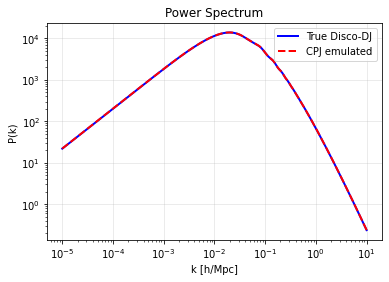

In [8]:
# For matter power spectrum: x-axis is k (wavenumber), log-log plot
plt.rcParams['figure.facecolor'] = 'white'

plt.loglog(k_modes, 10**testing_features[-1], 'b-', label='True Disco-DJ', linewidth=2)
plt.loglog(k_modes, preds[-1], 'r--', label='CPJ emulated', linewidth=2)
plt.xlabel('k [h/Mpc]')
plt.ylabel('P(k)')
plt.title('Power Spectrum')
plt.legend()
plt.grid(True, alpha=0.3)

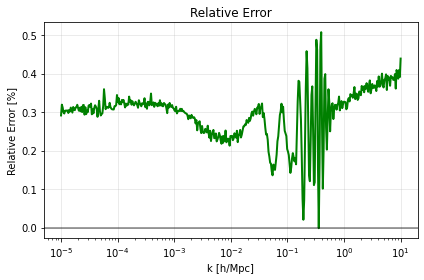

In [9]:
# Add a residual plot
# plt.subplot(2, 3, 6)
# Plot residuals for the first sample
residuals = (preds[-1] - 10**testing_features[-1]) / 10**testing_features[-1] * 100

plt.semilogx(k_modes, residuals, 'g-', linewidth=2)
plt.xlabel('k [h/Mpc]')

plt.ylabel('Relative Error [%]')
plt.title('Relative Error')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.5)

plt.tight_layout()

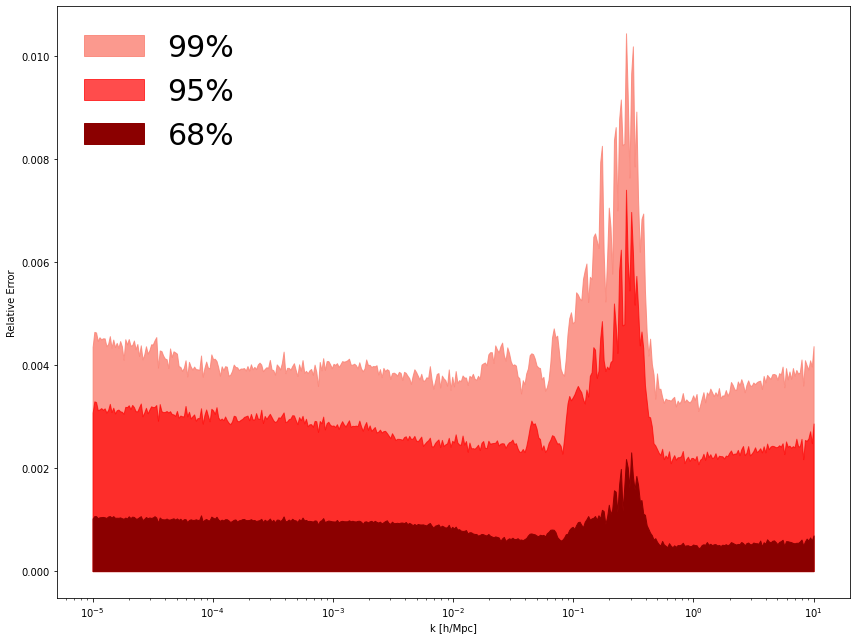

In [10]:
emulated_features = preds
diff=(emulated_features/10**testing_features-1) # Measure the relative difference between test sample and the emualted models
mean_diff = np.median(diff, axis = 0) #

# Compute percentiles
percentiles = np.zeros((4, diff.shape[1]))

percentiles[0] = np.percentile(diff, 68, axis = 0)
percentiles[1] = np.percentile(diff, 95, axis = 0)
percentiles[2] = np.percentile(diff, 99, axis = 0)
percentiles[3] = np.percentile(diff, 99.9, axis = 0)


plt.figure(figsize=(12, 9))
# plt.plot(k_modes, mean_diff,'-',color='black',label = 'mean')
plt.fill_between(k_modes, 0, percentiles[2,:], color = 'salmon', label = '99%', alpha=0.8)
plt.fill_between(k_modes, 0, percentiles[1,:], color = 'red', label = '95%', alpha = 0.7)
plt.fill_between(k_modes, 0, percentiles[0,:], color = 'darkred', label = '68%', alpha = 1)

# plt.ylim(0, 0.02)
plt.xscale('log')

plt.legend(frameon=False, fontsize=30, loc='upper left')
plt.ylabel('Relative Error')
plt.xlabel('k [h/Mpc]')

# ax = plt.gca()
# ax.xaxis.set_major_locator(plt.MaxNLocator(10))
# ax.yaxis.set_major_locator(plt.MaxNLocator(5))

# plt.setp(ax.get_xticklabels(), fontsize=25)
# plt.setp(ax.get_yticklabels(), fontsize=25)
plt.tight_layout()

### Calculating derivatives

In [8]:
dPk_batch = np.log(10) * derivative(weights, hyper_params, testing_parameters)
print(dPk_batch.shape)

(1000, 420, 6)


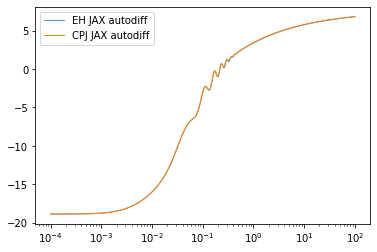

In [7]:
fig, ax = plt.subplots()
ax.semilogx(k_modes, diff_power_spectra[-1, :, 1] / power_spectra[-1], label=f'EH JAX autodiff', alpha=0.75, lw=1)
ax.semilogx(k_modes, dPk_batch[-1, :, 1], label='CPJ JAX autodiff', lw=1)
# ax.set_xlabel(r'$k\; [\text{Mpc}^{1}]$')
# ax.set_ylabel(r'$\partial \log P(k)/\partial \log \Omega_m\;[1]$')
# ax.set_ylim(-2,3)
ax.legend()